### Table of Contents:

### 1) Load Datasets and Create Dataframe
### 2) Feature Engineering
### 3) Prepare Data for Decision Tree
### 4) Create Classification Tree
#### 4a) Split Sets
#### 4b) Construct Tree
#### 4c) Prune Tree
#### 4d) Visualize Tree and Important Predictors
### 5) Use Group By to Analyze Differences in Male and Female Users
### 6) Create Time Series of Movie Release Years

In [1]:
# import appopriate libraries
import pandas as pd # loading in data
import numpy as np
import matplotlib.pyplot as plt # creating visualizations
import seaborn as sns # also for creating visualizations

plt.style.use('fivethirtyeight')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
lc = LabelEncoder()
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error #,mean_absolute_percentage_error

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, plot_roc_curve

from numpy import arange
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


!pip3 install opencv-python
import cv2

## Load Datasets and Create Dataframe

In [2]:
# Load datasets
users = pd.read_csv('users.dat', sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

ratings = pd.read_csv('ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'rating_timestamp'])
ratings["rating_timestamp"] = pd.to_datetime(ratings["rating_timestamp"], unit='s')

movies = pd.read_csv('movies.dat', sep='::', header=None, names=['movie_id', 'movie_title', 'genres'])

<ipython-input-2-4d1e84a31ec9>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('users.dat', sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
<ipython-input-2-4d1e84a31ec9>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'rating_timestamp'])
<ipython-input-2-4d1e84a31ec9>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this war

* The first number in a zip code corresponds to a region. Therefore, we will take the first number in the zip code to use later as a region indicator.

In [3]:
# Replace zip code with first integer (to mark region) in users data frame
for x in users.index:
    users.loc[x, 'zip_code'] = users.loc[x,'zip_code'][0]

* In order to combine all three data files into one dataset, we can use joins. Using inner joins will join only common data. This will avoid null values later.
* NOTE! - code for joins taken from an example in a DATA3550 lecture

In [4]:
# Combine datasets with inner joins

# Combine ratings and movies
df_movRat = pd.merge(ratings, movies, how = 'inner', on = ['movie_id'] )

# Add users to dataset
df_movRat = pd.merge(df_movRat, users, how = 'inner', on = ['user_id'])

In [5]:
# Confirm datasets combined correctly
df_movRat.head()

,user_id,movie_id,rating,rating_timestamp,movie_title,genres,gender,age,occupation,zip_code
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,4
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,4
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance,F,1,10,4
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,F,1,10,4
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,4


In [6]:
df_movRat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1000209 non-null  int64         
 1   movie_id          1000209 non-null  int64         
 2   rating            1000209 non-null  int64         
 3   rating_timestamp  1000209 non-null  datetime64[ns]
 4   movie_title       1000209 non-null  object        
 5   genres            1000209 non-null  object        
 6   gender            1000209 non-null  object        
 7   age               1000209 non-null  int64         
 8   occupation        1000209 non-null  int64         
 9   zip_code          1000209 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 83.9+ MB


* We will end up creating dummy variables for movie genres. However, as it stands, the sheer number of combinations of genres and sub genres makes the analysis cumbersome. Therefore, we will only take the main genre for each film and drop the sub genres. Keeping the sub genres is likely not to add enough benefit to overcome the sheer increase in dummy variables.

In [7]:
# Capture main genre without sub genres
df_movRat['genres'] = df_movRat['genres'].str.split('|').str[0].str.strip()

In [8]:
df_movRat.head()

,user_id,movie_id,rating,rating_timestamp,movie_title,genres,gender,age,occupation,zip_code
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,4
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation,F,1,10,4
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical,F,1,10,4
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,F,1,10,4
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation,F,1,10,4


## Feature Engineering

* The goal is to construct a decision tree to predict the likelihood a user is male. For each user_id, we will use the ratings database to determine how many movie ratings per genre each user gave. We will then determine how many total reviews each user_id left. Finally, we will derive the overall average rating left for each user_id.
* For example, user_id x left 2 action reviews and 1 thriller review for a total of 3 reviews. The overall average star rating left by user x across the three reviews is 4.

In [9]:
# Construct a copy of df_movRat to keep original database for any potential analysis outside of the feature engineering
df_movRat2 = df_movRat

* We will encode each genre with a numberical value. This numberical value will be used in if-then statements when iterating through the ratings database in order to tally the number of reviews each user_id left per genre

In [10]:
df_movRat2['genre_encode'] = lc.fit_transform(df_movRat['genres'])

* To iterate through the ratings database, we will use a counter variable to keep track of our place. Using this counter variable will allow us to avoid interating through the entire ratings database (1M records) for each user_id.
* We will use a while loop in the iteration process. The while loop terminates when the user_id in the ratings database does not match the respective user_id being compiled. In order for the entire iteration to work properly, it is imperative the layout of the user_ids in the ratings database matches the layout of user_ids in the user database. Therefore, we will need to sort the ratings database in ascending order by user_id.
* The while loop uses the .loc function. The counter variable feeds the .loc function. It is important the index of the database matches the counter variable. Since we have sorted the ratings database in ascending order, we need to reset the index. Resetting the index will ensure the counter variable corresponds with the proper record in regards to the .loc function.

In [11]:
# Arrange in ascending order by user_id for later sort
df_movRat2 = df_movRat2.sort_values(by='user_id')

# Reset index for later sort
df_movRat2 = df_movRat2.reset_index(drop=True)

In [12]:
# Confirm order of user_id and index are correct
# Notice index 181. The user_id moves from 2 to 3 without skipping an index number.
# A reset of the index allows for ascending order with sequential index numbers.
df_movRat2.head(185)

,user_id,movie_id,rating,rating_timestamp,movie_title,genres,gender,age,occupation,zip_code,genre_encode
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,4,7
1,1,745,3,2001-01-06 23:37:48,"Close Shave, A (1995)",Animation,F,1,10,4,2
2,1,2294,4,2001-01-06 23:38:11,Antz (1998),Animation,F,1,10,4,2
3,1,3186,4,2000-12-31 22:00:19,"Girl, Interrupted (1999)",Drama,F,1,10,4,7
4,1,1566,4,2001-01-06 23:38:50,Hercules (1997),Adventure,F,1,10,4,1
...,...,...,...,...,...,...,...,...,...,...,...
180,2,3256,2,2000-12-31 21:57:19,Patriot Games (1992),Action,M,56,16,7,0
181,2,3257,3,2000-12-31 22:01:13,"Bodyguard, The (1992)",Action,M,56,16,7,0
182,3,1394,4,2000-12-31 21:29:07,Raising Arizona (1987),Comedy,M,25,15,5,4
183,3,3868,3,2000-12-31 21:34:46,"Naked Gun: From the Files of Police Squad!, Th...",Comedy,M,25,15,5,4


* We used label encoding on the genres. Label encoding allows us to identify genres for tallying. We can use the code assigned to the genre in an if statment to tally the number of reviews by user for that particular genre.
* In order to use label encoding correctly, we need to confirm which genres were assigned which numbers. The following code block does that. Please note, we are only concered with genre_encode and genres (genre_encode is last column in output).
* NOTE! - The code in the below code block has been taken from stack overflow. I searched for a way to see label encode mapping.

In [13]:
# Confirm mapping of genres to proper encoding
# We only care about comparing the unique genere to the resprective genre_encode column
d1 = df_movRat2.drop_duplicates('genres').set_index('genres')
print(d1)

             user_id  movie_id  rating    rating_timestamp  \
genres                                                       
Drama              1      1193       5 2000-12-31 22:12:40   
Animation          1       745       3 2001-01-06 23:37:48   
Adventure          1      1566       4 2001-01-06 23:38:50   
Thriller           1      2762       4 2000-12-31 22:34:51   
Action             1      2692       4 2000-12-31 22:26:10   
Children's         1      1028       5 2000-12-31 22:29:37   
Crime              1       608       4 2000-12-31 22:23:18   
Musical            1       914       3 2000-12-31 22:32:48   
Comedy             1      2804       5 2000-12-31 22:11:59   
Romance            1      2340       3 2000-12-31 22:01:43   
Western            3      1266       5 2000-12-31 21:16:36   
Horror             5      3016       4 2000-12-31 05:53:36   
Documentary        5       162       4 2000-12-31 06:37:04   
Mystery            5      1909       3 2000-12-31 07:07:59   
Sci-Fi  

* We will now compare each unique user_id with all ratings left. Doing this will allow us to see how many movies of each genre a user reviewed.
* It is important the user_ids are arragned in ascending order. We do not have to search from the beginning each time if we know user_ids are in ascending order.
* In addition, it is important the index has been reset to ensure sequential order of the index. Sequential order of the index is important for the .loc function.

In [14]:
# Create temp databases to hold count of genre type and sum of all user ratings (for each genere)

dramaCount = []
dramaSum = []
dramaNumCount = 0
dramaNumSum = 0

animationCount = []
animationSum = []
animationNumCount = 0
animationNumSum = 0

musicalCount = []
musicalSum = []
musicalNumCount = 0
musicalNumSum = 0

actionCount = []
actionSum = []
actionNumCount = 0
actionNumSum = 0

comedyCount = []
comedySum = []
comedyNumCount = 0
comedyNumSum = 0

adventureCount = []
adventureSum = []
adventureNumCount = 0
adventureNumSum = 0

romanceCount = []
romanceSum = []
romanceNumCount = 0
romanceNumSum = 0

childCount = []
childSum = []
childNumCount = 0
childNumSum = 0

thrillerCount = []
thrillerSum = []
thrillerNumCount = 0
thrillerNumSum = 0

crimeCount = []
crimeSum = []
crimeNumCount = 0
crimeNumSum = 0

noirCount = []
noirSum = []
noirNumCount = 0
noirNumSum = 0

scifiCount = []
scifiSum = []
scifiNumCount = 0
scifiNumSum = 0

mysteryCount = []
mysterySum = []
mysteryNumCount = 0
mysteryNumSum = 0

horrorCount = []
horrorSum = []
horrorNumCount = 0
horrorNumSum = 0

westernCount = []
westernSum = []
westernNumCount = 0
westernNumSum = 0

documentaryCount = []
documentarySum = []
documentaryNumCount = 0
documentaryNumSum = 0

fantasyCount = []
fantasySum = []
fantasyNumCount = 0
fantasyNumSum = 0

warCount = []
warSum = []
warNumCount = 0
warNumSum = 0

# Create temp databases to hold total count of reviews and overall user ratings
totalCount = []
avgRating = []
totalNumCount = 0
totalNumSum = 0

x = 0 # Counter variable to hold our place

for userID in users['user_id']:
    
    # Reset all counts to zero when beginning a new user_id
    dramaNumCount = 0
    dramaNumSum = 0
    animationNumCount = 0
    animationNumSum = 0
    musicalNumCount = 0
    musicalNumSum = 0
    actionNumCount = 0
    actionNumSum = 0
    comedyNumCount = 0
    comedyNumSum = 0
    adventureNumCount = 0
    adventureNumSum = 0
    romanceNumCount = 0
    romanceNumSum = 0
    childNumCount = 0
    childNumSum = 0
    thrillerNumCount = 0
    thrillerNumSum = 0
    crimeNumCount = 0
    crimeNumSum = 0
    noirNumCount = 0
    noirNumSum = 0
    scifiNumCount = 0
    scifiNumSum = 0
    mysteryNumCount = 0
    mysteryNumSum = 0
    horrorNumCount = 0
    horrorNumSum = 0
    westernNumCount = 0
    westernNumSum = 0
    documentaryNumCount = 0
    documentaryNumSum = 0
    fantasyNumCount = 0
    fantasyNumSum = 0
    warNumCount = 0
    warNumSum = 0
    totalNumCount = 0
    totalNumSum = 0
    
    # Take each user_id, search the ratings database, and tally the number of ratings left for each genre
    while (df_movRat2.loc[x, 'user_id'] == userID) and (x < len(df_movRat2)-1):
        movEncode = df_movRat2.loc[x, 'genre_encode']
        if movEncode == 7:
            dramaNumCount = dramaNumCount + 1
            dramaNumSum = dramaNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 2:
            animationNumCount = animationNumCount + 1
            animationNumSum = animationNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 11:
            musicalNumCount = musicalNumCount + 1
            musicalNumSum = musicalNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 0:
            actionNumCount = actionNumCount + 1
            actionNumSum = actionNumSum + df_movRat2.loc[x, 'rating']
                
        elif movEncode == 4:
            comedyNumCount = comedyNumCount + 1
            comedyNumSum = comedyNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 1:
            adventureNumCount = adventureNumCount + 1
            adventureNumSum = adventureNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 13:
            romanceNumCount = romanceNumCount + 1
            romanceNumSum = romanceNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 3:
            childNumCount = childNumCount + 1
            childNumSum = childNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 15:
            thrillerNumCount = thrillerNumCount + 1
            thrillerNumSum = thrillerNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 5:
            crimeNumCount = crimeNumCount + 1
            crimeNumSum = crimeNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 9:
            noirNumCount = noirNumCount + 1
            noirNumSum = noirNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 14:
            scifiNumCount = scifiNumCount + 1
            scifiNumSum = scifiNumSum + df_movRat2.loc[x, 'rating']
                
        elif movEncode == 12:
            mysteryNumCount = mysteryNumCount + 1
            mysteryNumSum = mysteryNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 10:
            horrorNumCount = horrorNumCount + 1
            horrorNumSum = horrorNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 17:
            westernNumCount = westernNumCount + 1
            westernNumSum = westernNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 6:
            documentaryNumCount = documentaryNumCount + 1
            documentaryNumSum = documentaryNumSum + df_movRat2.loc[x, 'rating']

        elif movEncode == 8:
            fantasyNumCount = fantasyNumCount + 1
            fantasyNumSum = fantasyNumSum + df_movRat2.loc[x, 'rating']

        else:
            warNumCount = warNumCount + 1
            warNumSum = warNumSum + df_movRat2.loc[x, 'rating']
        
        # Find total counts (regardless of genre)
        # We will use this to find average rating of all reviews for the specific user
        totalNumCount = totalNumCount + 1
        totalNumSum = totalNumSum + df_movRat2.loc[x, 'rating']
            
        x = x + 1
    
    # Add the genre review count, total review count, and average rating tallies to current user_id
    # being interated
    totalCount.append(totalNumCount)
    avgRating.append(totalNumSum / totalNumCount) # average review for each user_id
    
    dramaCount.append(dramaNumCount)
    dramaSum.append(dramaNumSum)
 
    animationCount.append(animationNumCount)
    animationSum.append(animationNumSum)
    
    musicalCount.append(musicalNumCount)
    musicalSum.append(musicalNumSum)
    
    actionCount.append(actionNumCount)
    actionSum.append(actionNumSum)
    
    comedyCount.append(comedyNumCount)
    comedySum.append(comedyNumSum)
    
    adventureCount.append(adventureNumCount)
    adventureSum.append(adventureNumSum)
    
    romanceCount.append(romanceNumCount)
    romanceSum.append(romanceNumSum)
    
    childCount.append(childNumCount)
    childSum.append(childNumSum)
    
    thrillerCount.append(thrillerNumCount)
    thrillerSum.append(thrillerNumSum)

    crimeCount.append(crimeNumCount)
    crimeSum.append(crimeNumSum)
 
    noirCount.append(noirNumCount)
    noirSum.append(noirNumSum)
    
    scifiCount.append(scifiNumCount)
    scifiSum.append(scifiNumSum)
    
    mysteryCount.append(mysteryNumCount)
    mysterySum.append(mysteryNumSum)
    
    horrorCount.append(horrorNumCount)
    horrorSum.append(horrorNumSum)
    
    westernCount.append(westernNumCount)
    westernSum.append(westernNumSum)
    
    documentaryCount.append(documentaryNumCount)
    documentarySum.append(documentaryNumSum)
    
    fantasyCount.append(fantasyNumCount)
    fantasySum.append(fantasyNumSum)
    
    warCount.append(warNumCount)
    warSum.append(warNumSum)
    
    print('user_id ', userID, ' complete') # real time status update

user_id  1  complete
user_id  2  complete
user_id  3  complete
user_id  4  complete
user_id  5  complete
user_id  6  complete
user_id  7  complete
user_id  8  complete
user_id  9  complete
user_id  10  complete
user_id  11  complete
user_id  12  complete
user_id  13  complete
user_id  14  complete
user_id  15  complete
user_id  16  complete
user_id  17  complete
user_id  18  complete
user_id  19  complete
user_id  20  complete
user_id  21  complete
user_id  22  complete
user_id  23  complete
user_id  24  complete
user_id  25  complete
user_id  26  complete
user_id  27  complete
user_id  28  complete
user_id  29  complete
user_id  30  complete
user_id  31  complete
user_id  32  complete
user_id  33  complete
user_id  34  complete
user_id  35  complete
user_id  36  complete
user_id  37  complete
user_id  38  complete
user_id  39  complete
user_id  40  complete
user_id  41  complete
user_id  42  complete
user_id  43  complete
user_id  44  complete
user_id  45  complete
user_id  46  comple

user_id  386  complete
user_id  387  complete
user_id  388  complete
user_id  389  complete
user_id  390  complete
user_id  391  complete
user_id  392  complete
user_id  393  complete
user_id  394  complete
user_id  395  complete
user_id  396  complete
user_id  397  complete
user_id  398  complete
user_id  399  complete
user_id  400  complete
user_id  401  complete
user_id  402  complete
user_id  403  complete
user_id  404  complete
user_id  405  complete
user_id  406  complete
user_id  407  complete
user_id  408  complete
user_id  409  complete
user_id  410  complete
user_id  411  complete
user_id  412  complete
user_id  413  complete
user_id  414  complete
user_id  415  complete
user_id  416  complete
user_id  417  complete
user_id  418  complete
user_id  419  complete
user_id  420  complete
user_id  421  complete
user_id  422  complete
user_id  423  complete
user_id  424  complete
user_id  425  complete
user_id  426  complete
user_id  427  complete
user_id  428  complete
user_id  42

user_id  765  complete
user_id  766  complete
user_id  767  complete
user_id  768  complete
user_id  769  complete
user_id  770  complete
user_id  771  complete
user_id  772  complete
user_id  773  complete
user_id  774  complete
user_id  775  complete
user_id  776  complete
user_id  777  complete
user_id  778  complete
user_id  779  complete
user_id  780  complete
user_id  781  complete
user_id  782  complete
user_id  783  complete
user_id  784  complete
user_id  785  complete
user_id  786  complete
user_id  787  complete
user_id  788  complete
user_id  789  complete
user_id  790  complete
user_id  791  complete
user_id  792  complete
user_id  793  complete
user_id  794  complete
user_id  795  complete
user_id  796  complete
user_id  797  complete
user_id  798  complete
user_id  799  complete
user_id  800  complete
user_id  801  complete
user_id  802  complete
user_id  803  complete
user_id  804  complete
user_id  805  complete
user_id  806  complete
user_id  807  complete
user_id  80

user_id  1120  complete
user_id  1121  complete
user_id  1122  complete
user_id  1123  complete
user_id  1124  complete
user_id  1125  complete
user_id  1126  complete
user_id  1127  complete
user_id  1128  complete
user_id  1129  complete
user_id  1130  complete
user_id  1131  complete
user_id  1132  complete
user_id  1133  complete
user_id  1134  complete
user_id  1135  complete
user_id  1136  complete
user_id  1137  complete
user_id  1138  complete
user_id  1139  complete
user_id  1140  complete
user_id  1141  complete
user_id  1142  complete
user_id  1143  complete
user_id  1144  complete
user_id  1145  complete
user_id  1146  complete
user_id  1147  complete
user_id  1148  complete
user_id  1149  complete
user_id  1150  complete
user_id  1151  complete
user_id  1152  complete
user_id  1153  complete
user_id  1154  complete
user_id  1155  complete
user_id  1156  complete
user_id  1157  complete
user_id  1158  complete
user_id  1159  complete
user_id  1160  complete
user_id  1161  c

user_id  1466  complete
user_id  1467  complete
user_id  1468  complete
user_id  1469  complete
user_id  1470  complete
user_id  1471  complete
user_id  1472  complete
user_id  1473  complete
user_id  1474  complete
user_id  1475  complete
user_id  1476  complete
user_id  1477  complete
user_id  1478  complete
user_id  1479  complete
user_id  1480  complete
user_id  1481  complete
user_id  1482  complete
user_id  1483  complete
user_id  1484  complete
user_id  1485  complete
user_id  1486  complete
user_id  1487  complete
user_id  1488  complete
user_id  1489  complete
user_id  1490  complete
user_id  1491  complete
user_id  1492  complete
user_id  1493  complete
user_id  1494  complete
user_id  1495  complete
user_id  1496  complete
user_id  1497  complete
user_id  1498  complete
user_id  1499  complete
user_id  1500  complete
user_id  1501  complete
user_id  1502  complete
user_id  1503  complete
user_id  1504  complete
user_id  1505  complete
user_id  1506  complete
user_id  1507  c

user_id  1812  complete
user_id  1813  complete
user_id  1814  complete
user_id  1815  complete
user_id  1816  complete
user_id  1817  complete
user_id  1818  complete
user_id  1819  complete
user_id  1820  complete
user_id  1821  complete
user_id  1822  complete
user_id  1823  complete
user_id  1824  complete
user_id  1825  complete
user_id  1826  complete
user_id  1827  complete
user_id  1828  complete
user_id  1829  complete
user_id  1830  complete
user_id  1831  complete
user_id  1832  complete
user_id  1833  complete
user_id  1834  complete
user_id  1835  complete
user_id  1836  complete
user_id  1837  complete
user_id  1838  complete
user_id  1839  complete
user_id  1840  complete
user_id  1841  complete
user_id  1842  complete
user_id  1843  complete
user_id  1844  complete
user_id  1845  complete
user_id  1846  complete
user_id  1847  complete
user_id  1848  complete
user_id  1849  complete
user_id  1850  complete
user_id  1851  complete
user_id  1852  complete
user_id  1853  c

user_id  2176  complete
user_id  2177  complete
user_id  2178  complete
user_id  2179  complete
user_id  2180  complete
user_id  2181  complete
user_id  2182  complete
user_id  2183  complete
user_id  2184  complete
user_id  2185  complete
user_id  2186  complete
user_id  2187  complete
user_id  2188  complete
user_id  2189  complete
user_id  2190  complete
user_id  2191  complete
user_id  2192  complete
user_id  2193  complete
user_id  2194  complete
user_id  2195  complete
user_id  2196  complete
user_id  2197  complete
user_id  2198  complete
user_id  2199  complete
user_id  2200  complete
user_id  2201  complete
user_id  2202  complete
user_id  2203  complete
user_id  2204  complete
user_id  2205  complete
user_id  2206  complete
user_id  2207  complete
user_id  2208  complete
user_id  2209  complete
user_id  2210  complete
user_id  2211  complete
user_id  2212  complete
user_id  2213  complete
user_id  2214  complete
user_id  2215  complete
user_id  2216  complete
user_id  2217  c

user_id  2529  complete
user_id  2530  complete
user_id  2531  complete
user_id  2532  complete
user_id  2533  complete
user_id  2534  complete
user_id  2535  complete
user_id  2536  complete
user_id  2537  complete
user_id  2538  complete
user_id  2539  complete
user_id  2540  complete
user_id  2541  complete
user_id  2542  complete
user_id  2543  complete
user_id  2544  complete
user_id  2545  complete
user_id  2546  complete
user_id  2547  complete
user_id  2548  complete
user_id  2549  complete
user_id  2550  complete
user_id  2551  complete
user_id  2552  complete
user_id  2553  complete
user_id  2554  complete
user_id  2555  complete
user_id  2556  complete
user_id  2557  complete
user_id  2558  complete
user_id  2559  complete
user_id  2560  complete
user_id  2561  complete
user_id  2562  complete
user_id  2563  complete
user_id  2564  complete
user_id  2565  complete
user_id  2566  complete
user_id  2567  complete
user_id  2568  complete
user_id  2569  complete
user_id  2570  c

user_id  2883  complete
user_id  2884  complete
user_id  2885  complete
user_id  2886  complete
user_id  2887  complete
user_id  2888  complete
user_id  2889  complete
user_id  2890  complete
user_id  2891  complete
user_id  2892  complete
user_id  2893  complete
user_id  2894  complete
user_id  2895  complete
user_id  2896  complete
user_id  2897  complete
user_id  2898  complete
user_id  2899  complete
user_id  2900  complete
user_id  2901  complete
user_id  2902  complete
user_id  2903  complete
user_id  2904  complete
user_id  2905  complete
user_id  2906  complete
user_id  2907  complete
user_id  2908  complete
user_id  2909  complete
user_id  2910  complete
user_id  2911  complete
user_id  2912  complete
user_id  2913  complete
user_id  2914  complete
user_id  2915  complete
user_id  2916  complete
user_id  2917  complete
user_id  2918  complete
user_id  2919  complete
user_id  2920  complete
user_id  2921  complete
user_id  2922  complete
user_id  2923  complete
user_id  2924  c

user_id  3262  complete
user_id  3263  complete
user_id  3264  complete
user_id  3265  complete
user_id  3266  complete
user_id  3267  complete
user_id  3268  complete
user_id  3269  complete
user_id  3270  complete
user_id  3271  complete
user_id  3272  complete
user_id  3273  complete
user_id  3274  complete
user_id  3275  complete
user_id  3276  complete
user_id  3277  complete
user_id  3278  complete
user_id  3279  complete
user_id  3280  complete
user_id  3281  complete
user_id  3282  complete
user_id  3283  complete
user_id  3284  complete
user_id  3285  complete
user_id  3286  complete
user_id  3287  complete
user_id  3288  complete
user_id  3289  complete
user_id  3290  complete
user_id  3291  complete
user_id  3292  complete
user_id  3293  complete
user_id  3294  complete
user_id  3295  complete
user_id  3296  complete
user_id  3297  complete
user_id  3298  complete
user_id  3299  complete
user_id  3300  complete
user_id  3301  complete
user_id  3302  complete
user_id  3303  c

user_id  3618  complete
user_id  3619  complete
user_id  3620  complete
user_id  3621  complete
user_id  3622  complete
user_id  3623  complete
user_id  3624  complete
user_id  3625  complete
user_id  3626  complete
user_id  3627  complete
user_id  3628  complete
user_id  3629  complete
user_id  3630  complete
user_id  3631  complete
user_id  3632  complete
user_id  3633  complete
user_id  3634  complete
user_id  3635  complete
user_id  3636  complete
user_id  3637  complete
user_id  3638  complete
user_id  3639  complete
user_id  3640  complete
user_id  3641  complete
user_id  3642  complete
user_id  3643  complete
user_id  3644  complete
user_id  3645  complete
user_id  3646  complete
user_id  3647  complete
user_id  3648  complete
user_id  3649  complete
user_id  3650  complete
user_id  3651  complete
user_id  3652  complete
user_id  3653  complete
user_id  3654  complete
user_id  3655  complete
user_id  3656  complete
user_id  3657  complete
user_id  3658  complete
user_id  3659  c

user_id  3985  complete
user_id  3986  complete
user_id  3987  complete
user_id  3988  complete
user_id  3989  complete
user_id  3990  complete
user_id  3991  complete
user_id  3992  complete
user_id  3993  complete
user_id  3994  complete
user_id  3995  complete
user_id  3996  complete
user_id  3997  complete
user_id  3998  complete
user_id  3999  complete
user_id  4000  complete
user_id  4001  complete
user_id  4002  complete
user_id  4003  complete
user_id  4004  complete
user_id  4005  complete
user_id  4006  complete
user_id  4007  complete
user_id  4008  complete
user_id  4009  complete
user_id  4010  complete
user_id  4011  complete
user_id  4012  complete
user_id  4013  complete
user_id  4014  complete
user_id  4015  complete
user_id  4016  complete
user_id  4017  complete
user_id  4018  complete
user_id  4019  complete
user_id  4020  complete
user_id  4021  complete
user_id  4022  complete
user_id  4023  complete
user_id  4024  complete
user_id  4025  complete
user_id  4026  c

user_id  4334  complete
user_id  4335  complete
user_id  4336  complete
user_id  4337  complete
user_id  4338  complete
user_id  4339  complete
user_id  4340  complete
user_id  4341  complete
user_id  4342  complete
user_id  4343  complete
user_id  4344  complete
user_id  4345  complete
user_id  4346  complete
user_id  4347  complete
user_id  4348  complete
user_id  4349  complete
user_id  4350  complete
user_id  4351  complete
user_id  4352  complete
user_id  4353  complete
user_id  4354  complete
user_id  4355  complete
user_id  4356  complete
user_id  4357  complete
user_id  4358  complete
user_id  4359  complete
user_id  4360  complete
user_id  4361  complete
user_id  4362  complete
user_id  4363  complete
user_id  4364  complete
user_id  4365  complete
user_id  4366  complete
user_id  4367  complete
user_id  4368  complete
user_id  4369  complete
user_id  4370  complete
user_id  4371  complete
user_id  4372  complete
user_id  4373  complete
user_id  4374  complete
user_id  4375  c

user_id  4682  complete
user_id  4683  complete
user_id  4684  complete
user_id  4685  complete
user_id  4686  complete
user_id  4687  complete
user_id  4688  complete
user_id  4689  complete
user_id  4690  complete
user_id  4691  complete
user_id  4692  complete
user_id  4693  complete
user_id  4694  complete
user_id  4695  complete
user_id  4696  complete
user_id  4697  complete
user_id  4698  complete
user_id  4699  complete
user_id  4700  complete
user_id  4701  complete
user_id  4702  complete
user_id  4703  complete
user_id  4704  complete
user_id  4705  complete
user_id  4706  complete
user_id  4707  complete
user_id  4708  complete
user_id  4709  complete
user_id  4710  complete
user_id  4711  complete
user_id  4712  complete
user_id  4713  complete
user_id  4714  complete
user_id  4715  complete
user_id  4716  complete
user_id  4717  complete
user_id  4718  complete
user_id  4719  complete
user_id  4720  complete
user_id  4721  complete
user_id  4722  complete
user_id  4723  c

user_id  5047  complete
user_id  5048  complete
user_id  5049  complete
user_id  5050  complete
user_id  5051  complete
user_id  5052  complete
user_id  5053  complete
user_id  5054  complete
user_id  5055  complete
user_id  5056  complete
user_id  5057  complete
user_id  5058  complete
user_id  5059  complete
user_id  5060  complete
user_id  5061  complete
user_id  5062  complete
user_id  5063  complete
user_id  5064  complete
user_id  5065  complete
user_id  5066  complete
user_id  5067  complete
user_id  5068  complete
user_id  5069  complete
user_id  5070  complete
user_id  5071  complete
user_id  5072  complete
user_id  5073  complete
user_id  5074  complete
user_id  5075  complete
user_id  5076  complete
user_id  5077  complete
user_id  5078  complete
user_id  5079  complete
user_id  5080  complete
user_id  5081  complete
user_id  5082  complete
user_id  5083  complete
user_id  5084  complete
user_id  5085  complete
user_id  5086  complete
user_id  5087  complete
user_id  5088  c

user_id  5426  complete
user_id  5427  complete
user_id  5428  complete
user_id  5429  complete
user_id  5430  complete
user_id  5431  complete
user_id  5432  complete
user_id  5433  complete
user_id  5434  complete
user_id  5435  complete
user_id  5436  complete
user_id  5437  complete
user_id  5438  complete
user_id  5439  complete
user_id  5440  complete
user_id  5441  complete
user_id  5442  complete
user_id  5443  complete
user_id  5444  complete
user_id  5445  complete
user_id  5446  complete
user_id  5447  complete
user_id  5448  complete
user_id  5449  complete
user_id  5450  complete
user_id  5451  complete
user_id  5452  complete
user_id  5453  complete
user_id  5454  complete
user_id  5455  complete
user_id  5456  complete
user_id  5457  complete
user_id  5458  complete
user_id  5459  complete
user_id  5460  complete
user_id  5461  complete
user_id  5462  complete
user_id  5463  complete
user_id  5464  complete
user_id  5465  complete
user_id  5466  complete
user_id  5467  c

user_id  5776  complete
user_id  5777  complete
user_id  5778  complete
user_id  5779  complete
user_id  5780  complete
user_id  5781  complete
user_id  5782  complete
user_id  5783  complete
user_id  5784  complete
user_id  5785  complete
user_id  5786  complete
user_id  5787  complete
user_id  5788  complete
user_id  5789  complete
user_id  5790  complete
user_id  5791  complete
user_id  5792  complete
user_id  5793  complete
user_id  5794  complete
user_id  5795  complete
user_id  5796  complete
user_id  5797  complete
user_id  5798  complete
user_id  5799  complete
user_id  5800  complete
user_id  5801  complete
user_id  5802  complete
user_id  5803  complete
user_id  5804  complete
user_id  5805  complete
user_id  5806  complete
user_id  5807  complete
user_id  5808  complete
user_id  5809  complete
user_id  5810  complete
user_id  5811  complete
user_id  5812  complete
user_id  5813  complete
user_id  5814  complete
user_id  5815  complete
user_id  5816  complete
user_id  5817  c

In [15]:
# Add the counts and average review for each user to the users database

users['dramaCount'] = dramaCount
#users['dramaSum'] = dramaSum

users['animationCount'] = animationCount
#users['animationSum'] = animationSum

users['musicalCount'] = musicalCount
#users['musicalSum'] = musicalSum

users['actionCount'] = actionCount
#users['actionSum'] = actionSum

users['comedyCount'] = comedyCount
#users['comedySum'] = comedySum

users['adventureCount'] = adventureCount
#users['adventureSum'] = adventureSum

users['romanceCount'] = romanceCount
#users['romanceSum'] = romanceSum

users['childCount'] = childCount
#users['childSum'] = childSum

users['thrillerCount'] = thrillerCount
#users['thrillerSum'] = thrillerSum

users['crimeCount'] = crimeCount
#users['crimeSum'] = crimeSum

users['noirCount'] = noirCount
#users['noirSum'] = noirSum

users['scifiCount'] = scifiCount
#users['scifiSum'] = scifiSum

users['mysteryCount'] = mysteryCount
#users['mysterySum'] = mysterySum

users['horrorCount'] = horrorCount
#users['horrorSum'] = horrorSum

users['westernCount'] = westernCount
#users['westernSum'] = westernSum

users['documentaryCount'] = documentaryCount
#users['documentarySum'] = documentarySum

users['fantasyCount'] = fantasyCount
#users['fantasySum'] = fantasySum

users['warCount'] = warCount
#users['warSum'] = warSum

users['totalCount'] = totalCount
users['avgRating'] = avgRating

In [16]:
# Confirm data looks as expected
users.head()

,user_id,gender,age,occupation,zip_code,dramaCount,animationCount,musicalCount,actionCount,comedyCount,...,noirCount,scifiCount,mysteryCount,horrorCount,westernCount,documentaryCount,fantasyCount,warCount,totalCount,avgRating
0,1,F,1,10,4,14,17,3,5,6,...,0,0,0,0,0,0,0,0,53,4.188679
1,2,M,56,16,7,44,0,0,56,20,...,0,0,0,0,0,0,0,0,129,3.713178
2,3,M,25,15,5,2,3,0,23,16,...,0,0,0,0,1,0,0,0,51,3.901961
3,4,M,45,7,0,1,0,0,19,0,...,0,0,0,0,0,0,0,0,21,4.190476
4,5,M,25,20,5,74,3,0,31,48,...,1,1,1,6,1,6,0,0,198,3.146465


## Prepare Data for Decision Tree

* The decision tree cannot handle predictors of object datatype. Therefore, we will convert object datatypes to numerical datatypes.

In [17]:
# Convert gender to binary variable for use in decision tree
# female = 0; male = 1
users['gender'] = lc.fit_transform(users['gender'])

In [18]:
# Create dummy variables for occupation
dummies = pd.get_dummies(users['occupation'], prefix = 'occupation', prefix_sep = '_', drop_first = False)
dummies.columns.values

array(['occupation_0', 'occupation_1', 'occupation_2', 'occupation_3',
       'occupation_4', 'occupation_5', 'occupation_6', 'occupation_7',
       'occupation_8', 'occupation_9', 'occupation_10', 'occupation_11',
       'occupation_12', 'occupation_13', 'occupation_14', 'occupation_15',
       'occupation_16', 'occupation_17', 'occupation_18', 'occupation_19',
       'occupation_20'], dtype=object)

In [19]:
# Add occupation dummy variables to dataset
users = pd.concat([users, dummies[['occupation_0', 'occupation_1', 'occupation_2', 'occupation_3',
       'occupation_4', 'occupation_5', 'occupation_6', 'occupation_7',
       'occupation_8', 'occupation_9', 'occupation_10', 'occupation_11',
       'occupation_12', 'occupation_13', 'occupation_14', 'occupation_15',
       'occupation_16', 'occupation_17', 'occupation_18', 'occupation_19',
       'occupation_20']]], axis = 1)

In [20]:
# Drop occupation feature as we have created dummies for occupation
users = users.drop(['occupation'], axis = 1)

In [21]:
# Create dummy variables for age
dummies = pd.get_dummies(users['age'], prefix = 'age', prefix_sep = '_', drop_first = False)
dummies.columns.values

array(['age_1', 'age_18', 'age_25', 'age_35', 'age_45', 'age_50',
       'age_56'], dtype=object)

In [22]:
# Add age dummy variables to dataset
users = pd.concat([users, dummies[['age_1', 'age_18', 'age_25', 'age_35', 'age_45', 'age_50',
       'age_56']]], axis = 1)

In [23]:
# Drop age feature as we have created dummies for age
users =users.drop(['age'], axis = 1)

In [24]:
# Create dummy variables for zip_code
dummies = pd.get_dummies(users['zip_code'], prefix = 'zip', prefix_sep = '_', drop_first = False)
dummies.columns.values

array(['zip_0', 'zip_1', 'zip_2', 'zip_3', 'zip_4', 'zip_5', 'zip_6',
       'zip_7', 'zip_8', 'zip_9'], dtype=object)

In [25]:
# Add zip_code dummy variables to dataset
users = pd.concat([users, dummies[['zip_0', 'zip_1', 'zip_2', 'zip_3', 'zip_4', 'zip_5', 'zip_6',
       'zip_7', 'zip_8', 'zip_9']]], axis = 1)

In [26]:
# Drop zip_code feature as we have created dummies for zip_code
users = users.drop(['zip_code'], axis = 1)

In [27]:
# Check remaining variables for objects
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           6040 non-null   int64  
 1   gender            6040 non-null   int32  
 2   dramaCount        6040 non-null   int64  
 3   animationCount    6040 non-null   int64  
 4   musicalCount      6040 non-null   int64  
 5   actionCount       6040 non-null   int64  
 6   comedyCount       6040 non-null   int64  
 7   adventureCount    6040 non-null   int64  
 8   romanceCount      6040 non-null   int64  
 9   childCount        6040 non-null   int64  
 10  thrillerCount     6040 non-null   int64  
 11  crimeCount        6040 non-null   int64  
 12  noirCount         6040 non-null   int64  
 13  scifiCount        6040 non-null   int64  
 14  mysteryCount      6040 non-null   int64  
 15  horrorCount       6040 non-null   int64  
 16  westernCount      6040 non-null   int64  


In [28]:
# Drop user_id as this is a randomly assigned number which should have not impact on the model
users = users.drop(['user_id'], axis = 1)

In [29]:
# Take one final look at the data
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            6040 non-null   int32  
 1   dramaCount        6040 non-null   int64  
 2   animationCount    6040 non-null   int64  
 3   musicalCount      6040 non-null   int64  
 4   actionCount       6040 non-null   int64  
 5   comedyCount       6040 non-null   int64  
 6   adventureCount    6040 non-null   int64  
 7   romanceCount      6040 non-null   int64  
 8   childCount        6040 non-null   int64  
 9   thrillerCount     6040 non-null   int64  
 10  crimeCount        6040 non-null   int64  
 11  noirCount         6040 non-null   int64  
 12  scifiCount        6040 non-null   int64  
 13  mysteryCount      6040 non-null   int64  
 14  horrorCount       6040 non-null   int64  
 15  westernCount      6040 non-null   int64  
 16  documentaryCount  6040 non-null   int64  


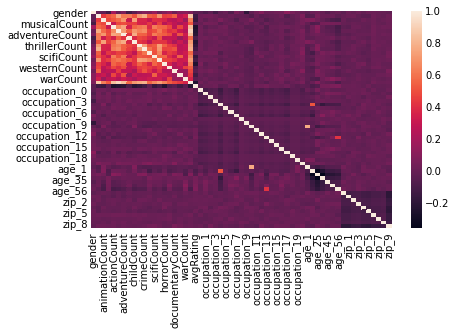

In [30]:
# Create correlation heat map
dataplot=sns.heatmap(users.corr())

## Create Classification Decision Tree

* NOTE! - the code used to split the data into training and testing sets has been taken from both a DATA1500 and DATA3550 lecture.

### Split Data into Training and Testing Sets

In [31]:
# Create target dataset
y = users.gender # Separating a target variable
y.head()

0    0
1    1
2    1
3    1
4    1
Name: gender, dtype: int32

In [32]:
# Create X matrix of predictors
X = users.drop('gender', axis = 1) # dropping the target variable to create the matrix of predictors X
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dramaCount        6040 non-null   int64  
 1   animationCount    6040 non-null   int64  
 2   musicalCount      6040 non-null   int64  
 3   actionCount       6040 non-null   int64  
 4   comedyCount       6040 non-null   int64  
 5   adventureCount    6040 non-null   int64  
 6   romanceCount      6040 non-null   int64  
 7   childCount        6040 non-null   int64  
 8   thrillerCount     6040 non-null   int64  
 9   crimeCount        6040 non-null   int64  
 10  noirCount         6040 non-null   int64  
 11  scifiCount        6040 non-null   int64  
 12  mysteryCount      6040 non-null   int64  
 13  horrorCount       6040 non-null   int64  
 14  westernCount      6040 non-null   int64  
 15  documentaryCount  6040 non-null   int64  
 16  fantasyCount      6040 non-null   int64  


In [33]:
# Create training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Construct Tree

Now that we have the split the data into training and testing splits, we can build the model.
* Before developing the model, it is useful to determine the baseline accuracy of the data. The baseline accuracy is how correct we would be if we predicted male for all users in the dataset. We are essentially expressing, as a percentage, how many users in the dataset are male. In order to be effective (when only overall accuracy is considered), the decision tree classification model must beat the baseline accuracy.
* NOTE! - The vast majority of code used in this section is taken from DATA1500 and DATA3550

In [34]:
# Baseline accuracy
users['gender'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

1    71.7%
0    28.3%
Name: gender, dtype: object

* We will fit the tree to the training data. Then, we will calculate a training and testing error rate.

In [35]:
clf_tree = DecisionTreeClassifier(class_weight = 'balanced')
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [36]:
y_predictions = clf_tree.predict(X_train)

In [37]:
score_train = clf_tree.score(X_train, y_train)
print(score_train)
print("")

1.0



Our model has a high training r square. However, a high r square is to be expected on the training set. We have not pruned the tree. Therefore, our decision is completely overfit to the training set. Essentially, we have allowed the tree to grow until it completely fits the training data. Thus, this model will perform poorly on any data outside of the training data.

### Prune Tree

* Fully grown trees suffer form overfitting. Therefore, in order to reduce overfitting and create more general trees, we can prune our fully grown decision tree. In order to prune our tree, we must pick a max depth. Otherwise, the tree will continue splitting until it is fully grown. It is proper to pick a max depth which results in the lowest error (or highest score). We can use cross validation and iterate through possible max depths to determine the optimal max depth for our model.
* NOTE - The code used to prune the tree has been taken from DATA3550.

iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done


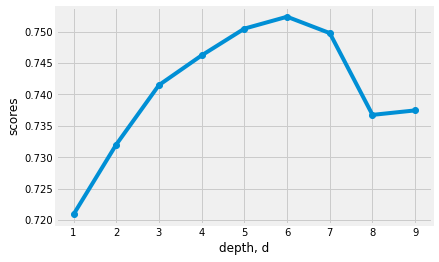

In [38]:
# Determine optimal tree max depth
depth = range(1,10)
scores = []

for d in depth:
    clf_tree = DecisionTreeClassifier(max_depth = d)
    clf_tree = clf_tree.fit(X_train,y_train)
    scores.append(cross_val_score(clf_tree, X_train, y_train, cv = 10).mean())
    print("iteration {} done".format(d))


plt.plot(depth, scores, '-o')
plt.xlabel('depth, d')
plt.ylabel('scores')
plt.xticks(depth)
plt.show()

* The max depth which results in the highest score is 6. Therefore, we can use 6 as our max depth when building our model.

In [39]:
clf_tree_optimal = DecisionTreeClassifier(max_depth = 6)
clf_tree_optimal.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [40]:
y_predictions_optimal = clf_tree_optimal.predict(X_test)

In [41]:
score_test_optimal = clf_tree_optimal.score(X_test, y_test)
print(score_test_optimal)
print("")

0.7450331125827815



In [42]:
print(confusion_matrix(y_test, y_predictions_optimal)) #returns confusion matrix
print("")
print(classification_report(y_test, y_predictions_optimal)) #returns the classification report

[[ 128  401]
 [  61 1222]]

              precision    recall  f1-score   support

           0       0.68      0.24      0.36       529
           1       0.75      0.95      0.84      1283

    accuracy                           0.75      1812
   macro avg       0.72      0.60      0.60      1812
weighted avg       0.73      0.75      0.70      1812



### Visualize Decision Tree and View Important Predictors

In [43]:
# NOTE! - The following code has been taken from Stack Overflow (In a prior Data class for an assignment)
export_graphviz(clf_tree_optimal,out_file='tree.dot',feature_names= X.columns,class_names=['Female', 'Male'])
! dot -Tpng tree.dot -o tree.png

Error: Could not open "tree.png" for writing : Invalid argument


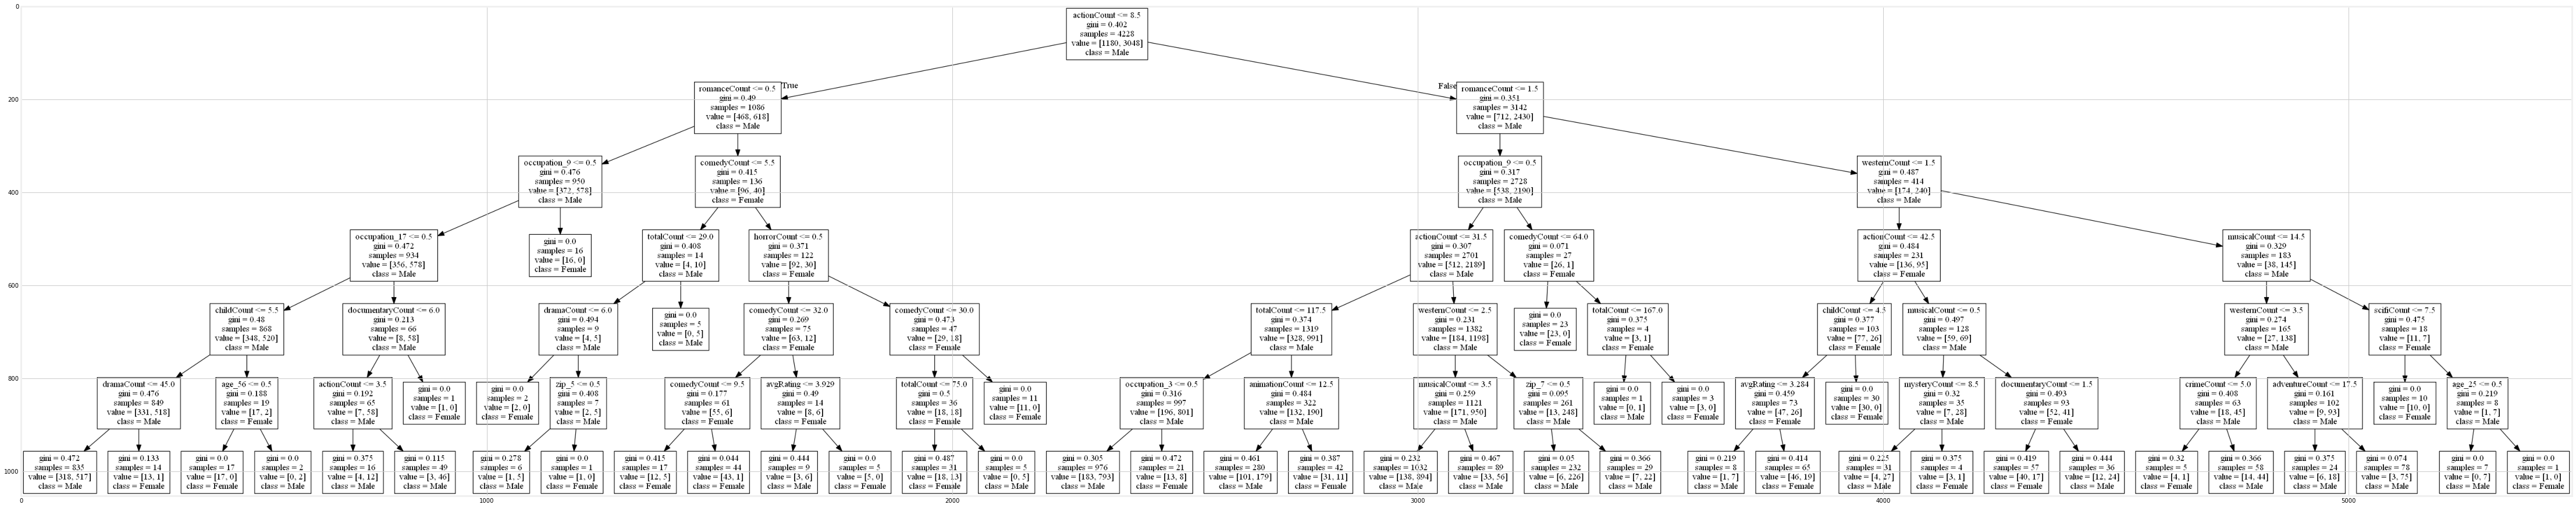

In [44]:
img = cv2.imread('tree.png')
plt.figure(figsize = (70, 70))
plt.imshow(img)

* Once the tree has been created, we can view the important features. A feature with an importance greater then zero has some impact on the likelihood a user_id belongs to a male vs a female.

In [45]:
# NOTE! - The following code has been taken from a DATA3550 lecture
feat_imp = pd.DataFrame(clf_tree_optimal.feature_importances_) # Display feature importance in the tree
names = pd.DataFrame(list(X.columns))
df_feat_imp = pd.concat([feat_imp, names], axis = 1)
df_feat_imp.columns = ['Importance', 'Features']
df_feat_imp.sort_values('Importance', ascending = False)

,Importance,Features
3,0.242474,actionCount
6,0.150281,romanceCount
29,0.111619,occupation_9
14,0.094219,westernCount
18,0.066911,totalCount
2,0.056454,musicalCount
4,0.045677,comedyCount
7,0.041495,childCount
1,0.026372,animationCount
37,0.024331,occupation_17


## Use Group By to Look at Differences in Males and Females

* It could be useful to see the differences in an average male and an average female profile. For example, do males tend to review some genres more than females?
* We can use the group by function to look at the average value for each predictor by gender. This will allow us to gain additiona insight into the data.
* NOTE! - group by code has been taken from stack overflow

In [46]:
# In order to see every column in the means table
pd.set_option("display.max_columns", None)

In [47]:
# 0 = female; 1 = male
means = users.groupby('gender').mean().transpose()
means

gender,0,1
dramaCount,35.951434,33.984299
animationCount,6.388531,6.007389
musicalCount,1.664131,0.985454
actionCount,26.711527,48.904872
comedyCount,44.996489,46.184253
adventureCount,6.039789,7.690603
romanceCount,0.695728,0.379358
childCount,3.891164,3.426691
thrillerCount,2.523113,3.126068
crimeCount,4.922762,6.796583


## Create Time Series of Movie Release Years

* It is possible older users may inherently rate older movies higher, and younger users may rate newer movies higher. All things equal, one might inherently be more fond of a movie from their generation; therefore, artifically affecting their final rating. In order to examine this, we can create a time series using movie release years.

In [48]:
print(df_movRat.movie_title)

0          One Flew Over the Cuckoo's Nest (1975)
1                James and the Giant Peach (1996)
2                             My Fair Lady (1964)
3                          Erin Brockovich (2000)
4                            Bug's Life, A (1998)
                            ...                  
1000204                          Footloose (1984)
1000205                    MacKenna's Gold (1969)
1000206                        Pumpkinhead (1988)
1000207                  Missing in Action (1984)
1000208                       Bronco Billy (1980)
Name: movie_title, Length: 1000209, dtype: object


In [49]:
# Create a new variable from "movie_title" by deleting the movie name title
# and keeping only the movie release year.

df_movRat['movie_year'] = df_movRat['movie_title'].str.replace(r'\D+', '')

In [50]:
# convert to datetime64 data type 
df_movRat['movie_year'] = pd.to_datetime(df_movRat['movie_year'],format='%Y', errors = 'coerce' )

In [51]:
# Confirm if it is converted correctly 
print(df_movRat.movie_year)

0         1975-01-01
1         1996-01-01
2         1964-01-01
3         2000-01-01
4         1998-01-01
             ...    
1000204   1984-01-01
1000205   1969-01-01
1000206   1988-01-01
1000207   1984-01-01
1000208   1980-01-01
Name: movie_year, Length: 1000209, dtype: datetime64[ns]


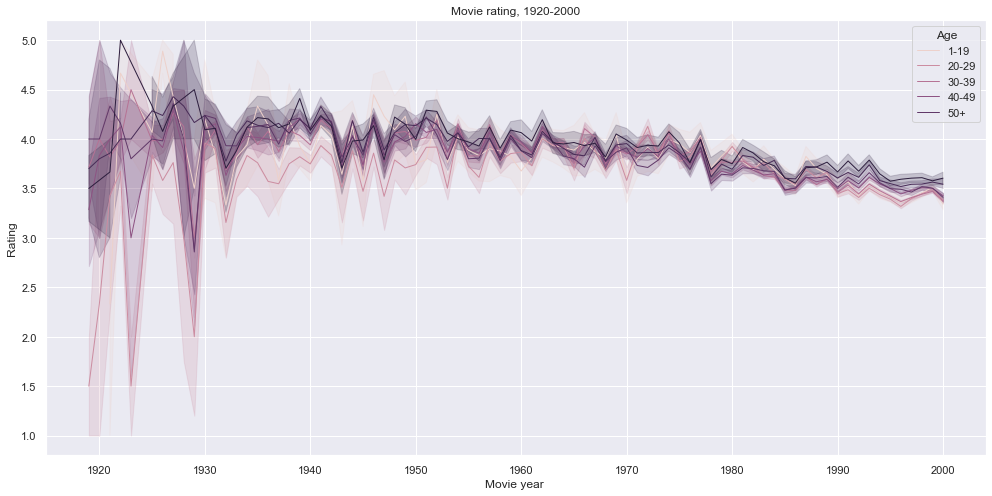

In [52]:
# Time-series graphs to visualize trends in rating and age values over time.
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=df_movRat, x="movie_year", y="rating", hue="age",linewidth = 1)
plt.title('Movie rating, 1920-2000')
plt.xlabel('Movie year ')
plt.ylabel('Rating')

plt.legend(title='Age',  labels=['1-19', '20-29','30-39','40-49','50+'])

* Based on the above plot, it does appear the lowest reviews for older movies come from younger age groups.